### Investigate if there's a potential feedback confound in the pref vs. not pref analysis
- Look at correct to incorrect ratio, across the 3 conditions. chosen pref, chosen not pref, not chosen not pref
- Plot at distribution across sessions, features

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
import scipy.stats


In [3]:
num_bins = 2

def get_sess_ratios(row, beh_path, sub):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session, sub=sub)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session, sub)
    beh = behavioral_utils.get_belief_value_labels(beh)
    res = []
    for feat in FEATURES: 
        pref_all = behavioral_utils.get_chosen_preferred_single(feat, beh)
        pref = pref_all[pref_all.Choice == feat]
        other = pref_all[pref_all.Choice == "other"]
        not_pref = behavioral_utils.get_chosen_not_preferred_single(feat, beh)
        not_pref = not_pref[not_pref.Choice == feat]
        pref_rat = len(pref[pref.Response == "Correct"]) / len(pref)
        not_pref_rat = len(not_pref[not_pref.Response == "Correct"]) / len(not_pref)
        other_rat = len(other[other.Response == "Correct"]) / len(other)
        res.append({
            "session": session, 
            "feat": feat, 
            "pref_ratio": pref_rat,
            "not_pref_ratio": not_pref_rat,
            "other_ratio": other_rat,
        })
    return pd.DataFrame(res)

In [4]:
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
all_beh = pd.concat(sessions.apply(lambda x: get_sess_ratios(x, beh_path, "SA"), axis=1).values).reset_index()

ZeroDivisionError: division by zero

In [8]:
all_beh

,index,session,feat,pref_ratio,not_pref_ratio,other_ratio
0,0,20180709,CIRCLE,0.502994,0.502994,0.648208
1,1,20180709,SQUARE,0.555556,0.555556,0.643636
2,2,20180709,STAR,0.511905,0.511905,0.638710
3,3,20180709,TRIANGLE,0.445455,0.445455,0.645503
4,4,20180709,CYAN,0.565421,0.565421,0.630972
...,...,...,...,...,...,...
535,7,20180910,YELLOW,0.436782,0.436782,0.607619
536,8,20180910,ESCHER,0.512563,0.512563,0.588968
537,9,20180910,POLKADOT,0.475676,0.475676,0.592466
538,10,20180910,RIPPLE,0.406780,0.406780,0.585014


In [9]:
melted = all_beh.melt(id_vars=["index", "session", "feat"], value_vars=["pref_ratio", "not_pref_ratio", "other_ratio"], var_name="condition", value_name="correct ratio")

<Axes: xlabel='condition', ylabel='correct ratio'>

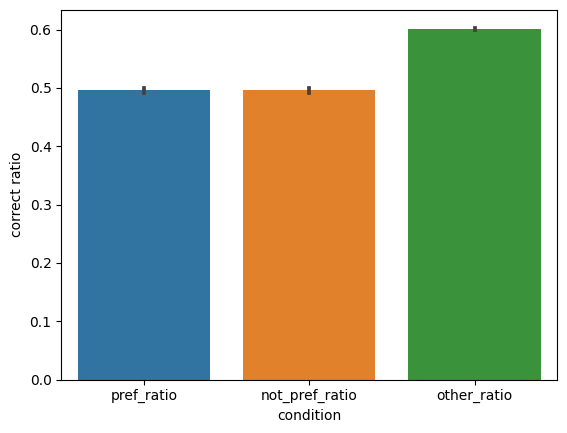

In [11]:
sns.barplot(melted, x="condition", y="correct ratio")